In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc 

In [ ]:
tf.keras.backend.set_floatx("float64")

In [ ]:
### Generating data

# number of boundary and initial data points

number_of_ic_points = 50
number_of_bc1_points = 25
number_of_bc2_points = 25

# Latin Hypercube Sampling (LHS) engine ; to sample random points in domain,
# boundary and initial boundary
engine = qmc.LatinHypercube(d=1)

# temporal data points
t_d = engine.random(n=number_of_bc1_points + number_of_bc2_points)
temp = np.zeros([number_of_ic_points, 1]) # for IC ; t = 0
t_d = np.append(temp, t_d, axis=0)

# spatial data points
x_d = engine.random(n=number_of_ic_points)
x_d = 2 * (x_d - 0.5)
temp1 = -1 * np.ones([number_of_bc1_points, 1]) # for BC1 ; x = -1
temp2 = +1 * np.ones([number_of_bc2_points, 1]) # for BC2 ; x = +1
x_d = np.append(x_d, temp1, axis=0)
x_d = np.append(x_d, temp2, axis=0)

Text(0.5, 1.0, 'Data points (BCs & IC)')

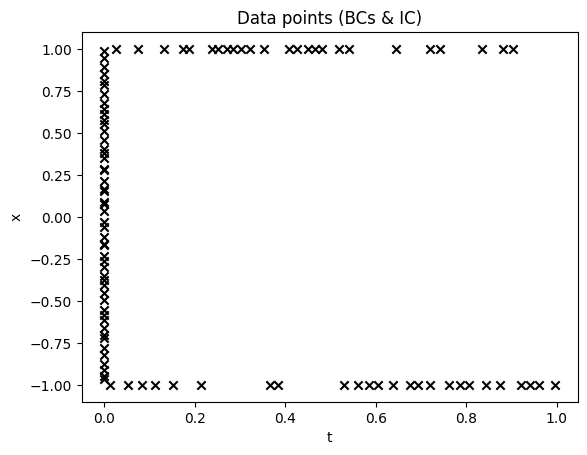

In [ ]:
# view randomly sampled boundary and initial points
plt.scatter(t_d, x_d, marker="x", c="k")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Data points (BCs & IC)")

In [ ]:
#First step(Aktastar):
L = 3000
t_sec = 3
rs = 2700
cs= 3000
r0 = 1000
r1 = rs / r0
m = 0
g = 10
g_ss = g*t_sec**2
alfa_t = L / g_ss
alfa_ps = r1*cs**2 / (alfa_t * L * g)
alfa_pf = 0
alfa_m = 2*5*10**(-3) / (alfa_t * t_sec * L * g * r0)
c1 = 3000
rd1 = 2.7
#rd = m*rf+ (1-m)*rs
print(alfa_t)
print(alfa_ps)
print(alfa_m)

33.333333333333336
24.3
3.3333333333333335e-12


In [ ]:
# output values for data points (boundary and initial)
y_d = np.zeros(x_d.shape)

# for initial condition: IC = -sin(pi*x)
y_d[ : number_of_ic_points] = -np.sin(np.pi * x_d[:number_of_ic_points])

# all boundary conditions are set to zero
y_d[number_of_ic_points : number_of_bc1_points + number_of_ic_points] = 0
y_d[number_of_bc1_points + number_of_ic_points : number_of_bc1_points + number_of_ic_points + number_of_bc2_points] = 0

In [ ]:
# number of collocation points
Nc = 10000

# LHS for collocation points
engine = qmc.LatinHypercube(d=2)
data = engine.random(n=Nc)
# set x values between -1. and +1.
data[:, 1] = 2*(data[:, 1]-0.5)

# change names
t_c = np.expand_dims(data[:, 0], axis=1)
x_c = np.expand_dims(data[:, 1], axis=1)

In [ ]:
# convert all data and collocation points to tf.Tensor
x_d, t_d, y_d, x_c, t_c = map(tf.convert_to_tensor, [x_d, t_d, y_d, x_c, t_c])

In [ ]:
### model design

def model_builder(input_shape=2, output_shape=1, n_hidden_layers=10, 
                neuron_per_layer=20, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(input_shape,))

    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]

    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])

    # building the model
    model = tf.keras.Model(input_layer, output_layer)
    
    return model

In [ ]:
model = model_builder(2, 1, 9, 20, "tanh")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420   

In [ ]:
@tf.function
def u(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u

In [ ]:
@tf.function
def f(x, y):
    u0 = u(x, y)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    F =  (1.0 / r1) *(u_xx - (1.0 / c1**2)* u_yy)
    return tf.reduce_mean(tf.square(F))

In [ ]:
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))
     

In [ ]:

import time

In [ ]:
tf.config.run_functions_eagerly(False)

In [ ]:
"""
BENCHMARK on Google Colab GPU

learning_rate = 5e-4
epochs = 2000
training time ~ 85.60 s
final loss = 0.006
"""

epochs = 100
loss_list = []

# L-BFGS optimizer was used in the reference paper
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
start = time.time()

# training loop
# IMPORTANT: a while-based training loop is more beneficial
# updates the model while loss > 0.006
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # model output/prediction
        y_ = u(t_d, x_d)
        # physics-informed loss for collocation points
        L1 = f(t_c, x_c)
        # MSE loss for data points
        L2 = mse(y_d, y_)
        loss = L1 + L2
    # compute gradients
    g = tape.gradient(loss, model.trainable_weights)
    loss_list.append(loss)

    # apply gradients
    opt.apply_gradients(zip(g, model.trainable_weights))

end = time.time()
print(f"{end - start:.3} (s)")

70.8 (s)


In [ ]:
for i in loss_list:
  print(i)

tf.Tensor(0.21660298443664797, shape=(), dtype=float64)
tf.Tensor(0.2055531001600233, shape=(), dtype=float64)
tf.Tensor(0.20024367529954884, shape=(), dtype=float64)
tf.Tensor(0.1992355072262292, shape=(), dtype=float64)
tf.Tensor(0.20001303287152242, shape=(), dtype=float64)
tf.Tensor(0.2005533120420971, shape=(), dtype=float64)
tf.Tensor(0.20009976008908548, shape=(), dtype=float64)
tf.Tensor(0.19883420018197115, shape=(), dtype=float64)
tf.Tensor(0.19728108918996595, shape=(), dtype=float64)
tf.Tensor(0.19592626958361933, shape=(), dtype=float64)
tf.Tensor(0.19504539092071474, shape=(), dtype=float64)
tf.Tensor(0.19465733040419017, shape=(), dtype=float64)
tf.Tensor(0.1945695859215815, shape=(), dtype=float64)
tf.Tensor(0.1944946864919713, shape=(), dtype=float64)
tf.Tensor(0.19418752582382137, shape=(), dtype=float64)
tf.Tensor(0.1935379081758101, shape=(), dtype=float64)
tf.Tensor(0.19258516409669874, shape=(), dtype=float64)
tf.Tensor(0.19147083365810605, shape=(), dtype=float64

Text(0.5, 0, 'epoch')

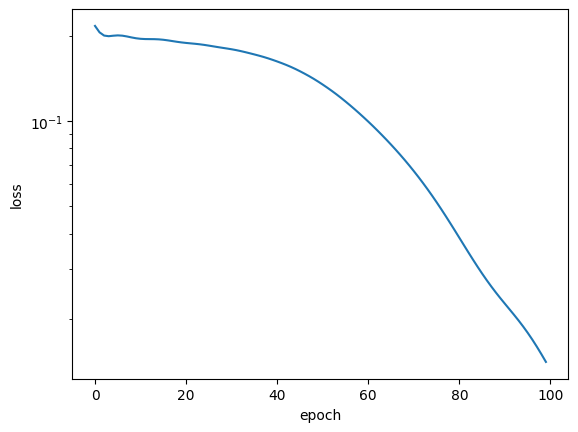

In [ ]:
plt.semilogy(range(epochs), loss_list)
plt.ylabel("loss")
plt.xlabel("epoch")

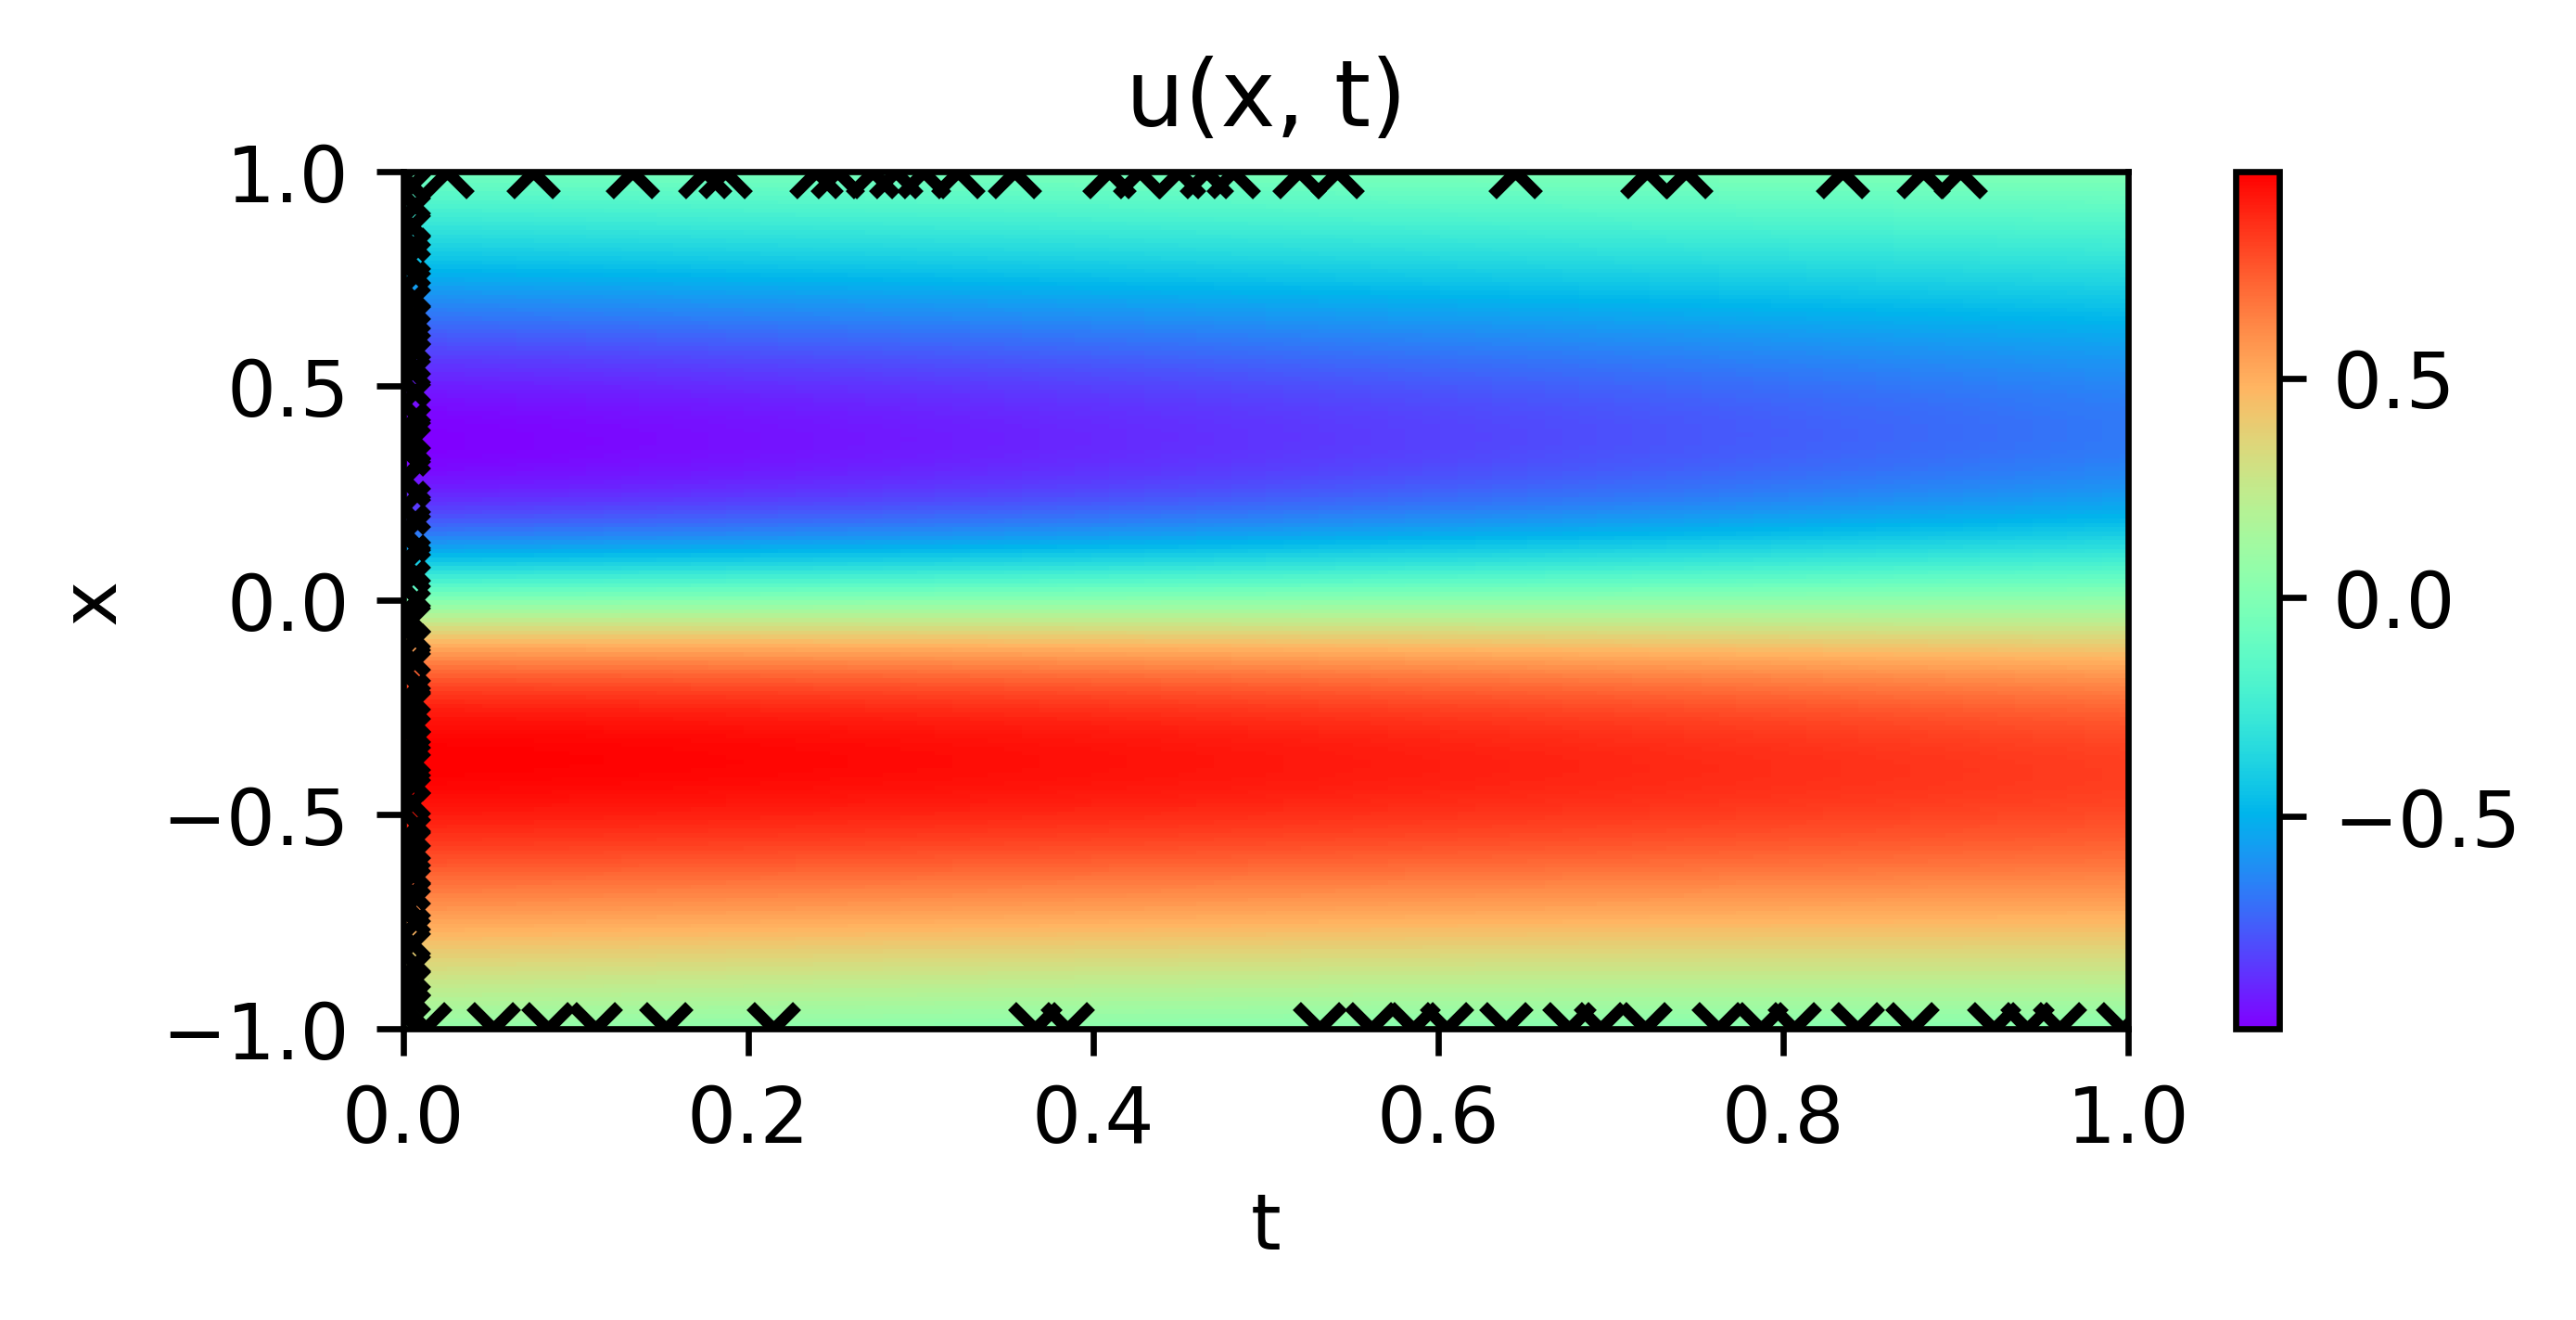

In [ ]:
n, m = 100, 200
X = np.linspace(-1, +1, m)
T = np.linspace(0, 1, n)
X0, T0 = np.meshgrid(X, T)
X = X0.reshape([n*m, 1])
T = T0.reshape([n*m, 1])
X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)
X.shape, T.shape
plt.figure(figsize=(5, 2), dpi=600)
S = u(T, X)
S = S.numpy().reshape(n, m)
plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(-1, +1)
plt.title("u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
plt.scatter(t_d, x_d, marker="x", c="k")
plt.show()
     

In [ ]:
model.save("burgers0.h5")
! cp burgers0.h5 drive/MyDrive

cp: cannot create regular file 'drive/MyDrive': No such file or directory


In [ ]:
address = "/content/burgers0.h5" # change this
burgers_net = tf.keras.models.load_model(address)

# make a function `u(t, x)` to use model easier
u = lambda t, x: burgers_net(tf.concat([t, x], axis=1))

63/63 [==============================] - 0s 2ms/step


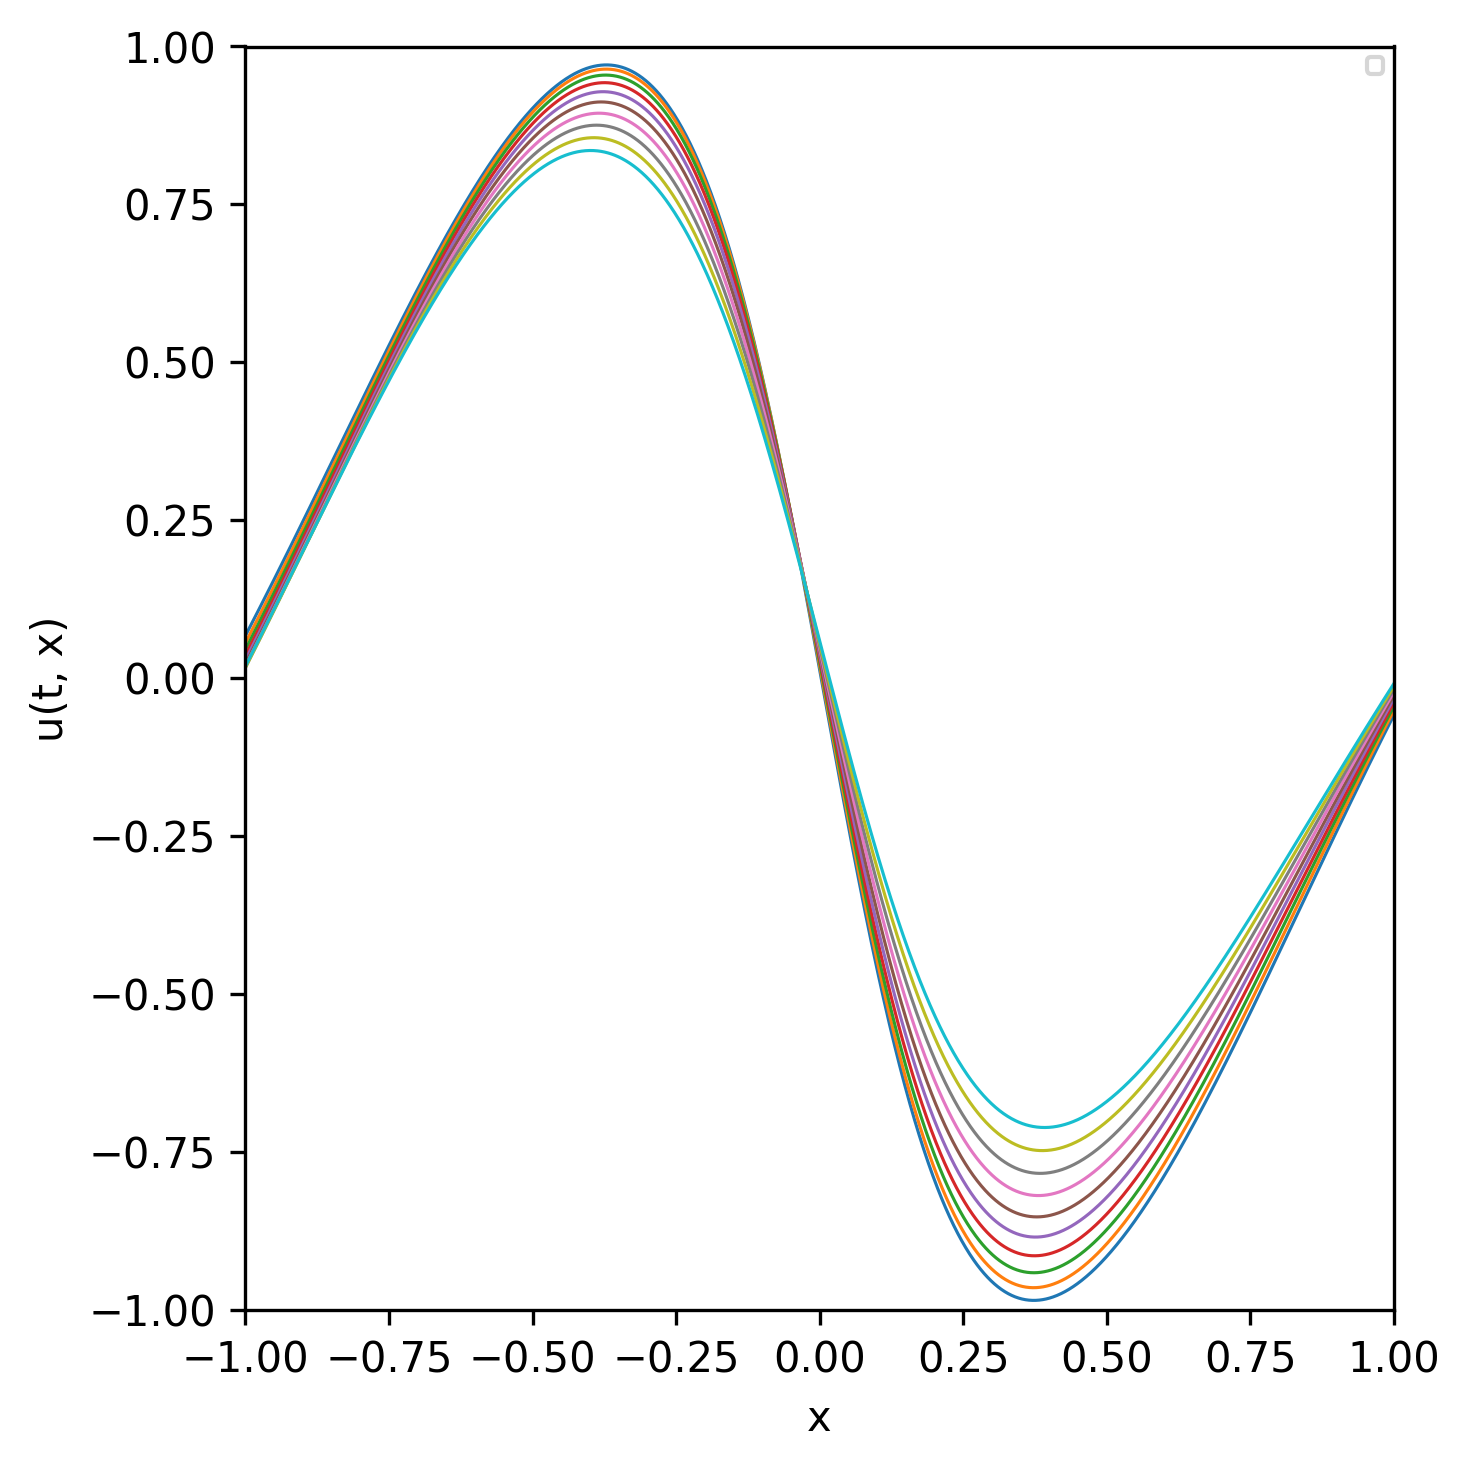

In [ ]:
plt.figure(figsize=(5, 5), dpi=300)
# input shape
n_temporal, n_spatial = 10, 2000
# combine (x, t) as a vector
v = np.zeros([n_spatial, 2]) # v[:, 0] = t, v[:, 1] = x
v[:, 1] = np.linspace(-1, +1, n_spatial)
# change t
for i in range(n_temporal):
    v[:, 0] = i/n_temporal
    plt.plot(v[:, 1], burgers_net.predict(v), lw=0.75)

plt.legend(loc="upper right", fontsize=5)
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.ylabel(f"u(t, x)")
plt.xlabel(f"x")
plt.tight_layout()
plt.savefig("u-constant-time.png")
plt.show()

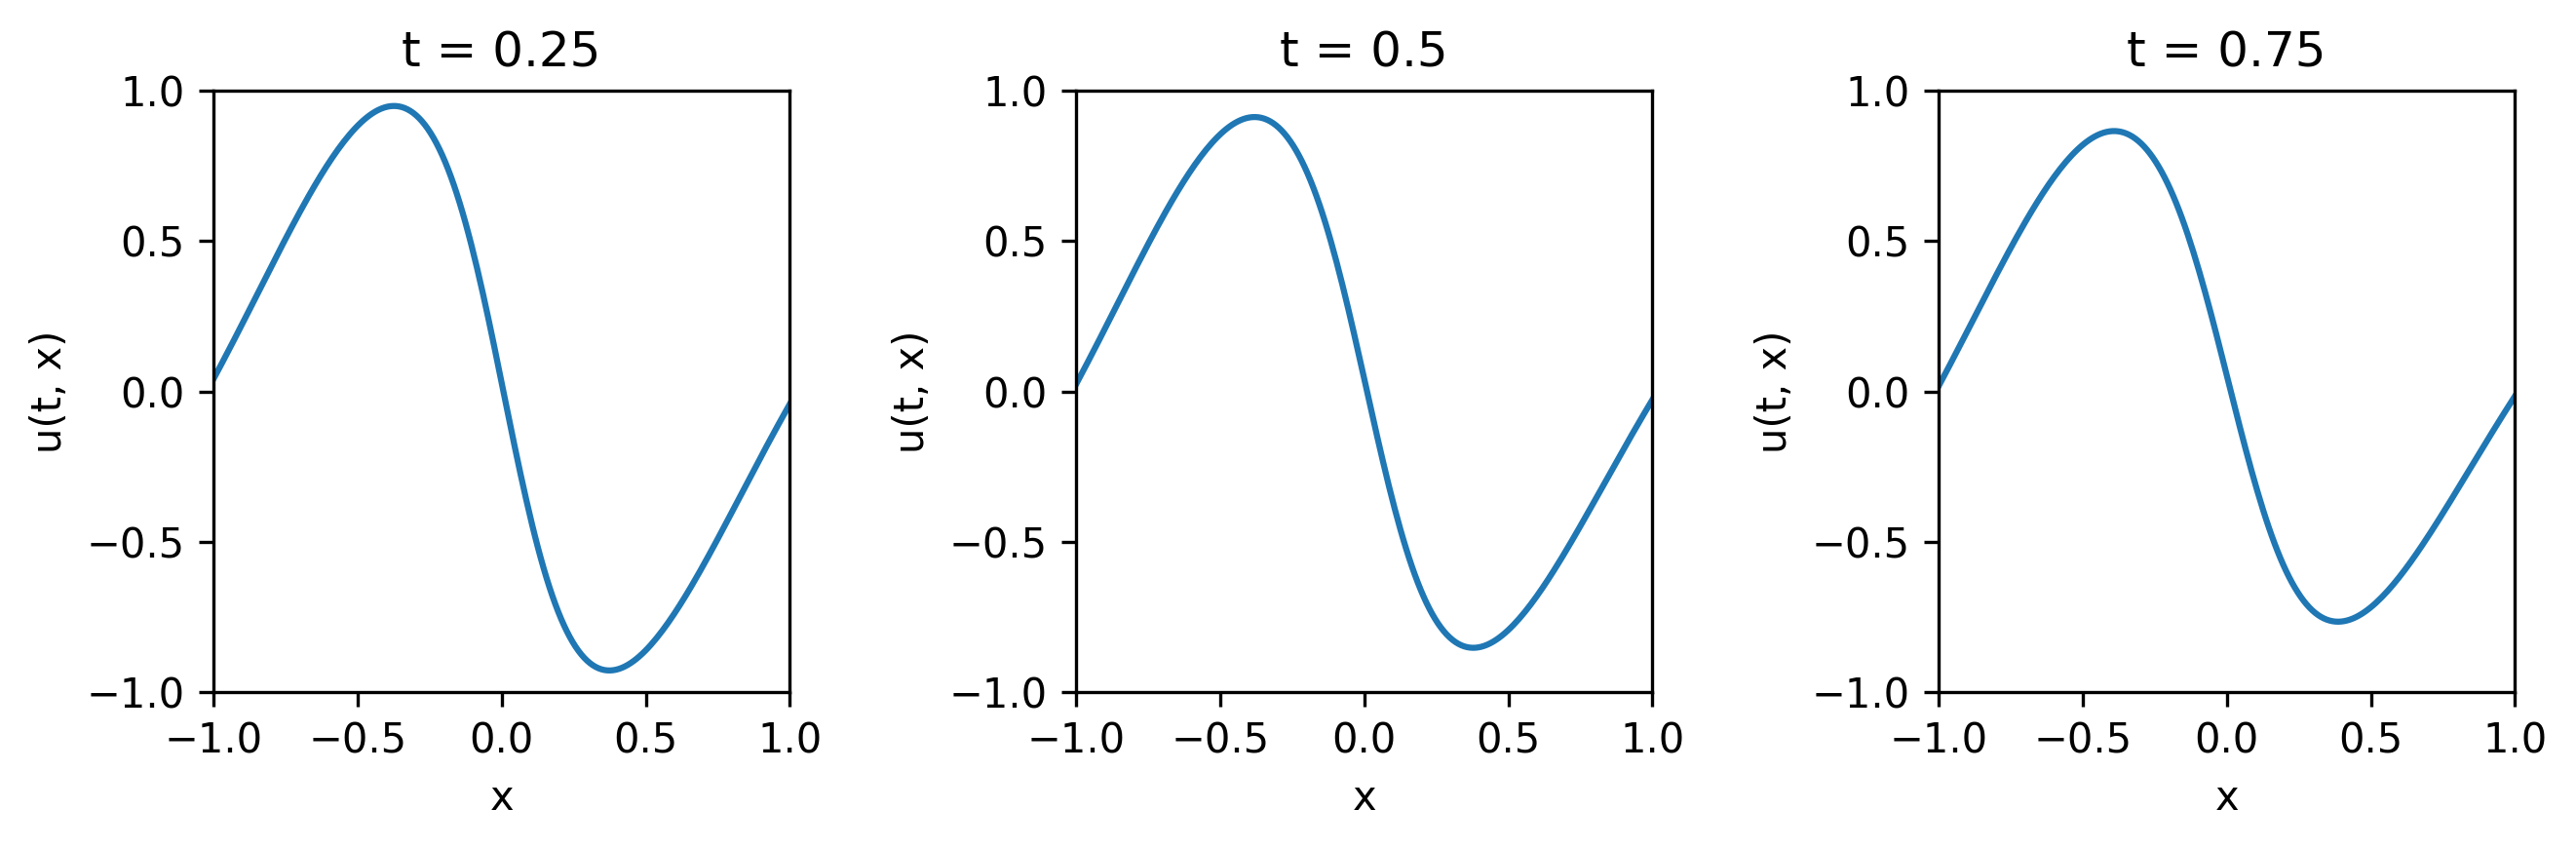

In [ ]:
x = np.expand_dims(np.linspace(-1, +1, 200), axis=1)

plt.figure(figsize=(9, 3), dpi=300)
for i, time_point in enumerate([0.25, 0.50, 0.75], start=1):
    t = np.ones_like(x) * time_point
    plt.subplot(130+i)
    plt.title(f"t = {time_point}")
    plt.plot(x, u(t, x))
    plt.ylabel(f"u(t, x)")
    plt.xlabel(f"x")
    plt.xlim(-1, +1)
    plt.ylim(-1, +1)

#
plt.tight_layout()
plt.savefig("u-vs-x.png")
plt.show()

In [ ]:
#Second step
L = 3000
t_sec = 3
rs = 2700
cs= 3000
r0 = 1000
r1 = rs / r0
m = 0
g = 10
g_ss = g*t_sec**2
alfa_t = L / g_ss
alfa_ps = r1*cs**2 / (alfa_t * L * g)
alfa_pf = 0
alfa_m = 2*5*10**(-3) / (alfa_t * t_sec * L * g * r0)
c1 = 3000
rd1 = 2.7
#rd = m*rf+ (1-m)*rs
print(alfa_t)
print(alfa_ps)
print(alfa_m)

rs2 = 2250
cs2= 2500
r2 = rs2 / r0
alfa_ps2 = r2*cs2**2 / (alfa_t * L * g)
rf2 = 850
cf2 = 1330
rf22 = rf2 / r0
alfa_pf2 = rf22*cf2**2 / (alfa_t * L * g)
m2 = 0.05
rd2 = m2*rf22 + (1-m2)*r2 
c2 = 1 / (m2/alfa_pf2 + (1-m2)/alfa_ps2)

print(alfa_pf2)
print(alfa_ps2)
print(rd2)
print(c2)


33.333333333333336
24.3
3.3333333333333335e-12
1.503565
14.0625
2.1799999999999997
9.919665144937625


In [ ]:
@tf.function
def u1(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u

In [ ]:
@tf.function
def f1(x, y):
    u0 = u(x, y)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    F =  (1.0 / rd2) *(u_xx - (1.0 / c2**2)* u_yy)
    return tf.reduce_mean(tf.square(F))

In [ ]:
@tf.function
def mse1(y, y_):
    return tf.reduce_mean(tf.square(y-y_))
     

In [ ]:
epochs = 100
loss_list1 = []

# L-BFGS optimizer was used in the reference paper
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
start = time.time()

# training loop
# IMPORTANT: a while-based training loop is more beneficial
# updates the model while loss > 0.006
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # model output/prediction
        y_ = u1(t_d, x_d)
        # physics-informed loss for collocation points
        L1 = f1(t_c, x_c)
        # MSE loss for data points
        L2 = mse1(y_d, y_)
        loss = L1 + L2
    # compute gradients
    g = tape.gradient(loss, model.trainable_weights)
    loss_list1.append(loss)

    # apply gradients
    opt.apply_gradients(zip(g, model.trainable_weights))

end = time.time()
print(f"{end - start:.3} (s)")

42.2 (s)


In [ ]:
for i in loss_list1:
  print(i)

tf.Tensor(0.012182577873748088, shape=(), dtype=float64)
tf.Tensor(0.03434544617774769, shape=(), dtype=float64)
tf.Tensor(0.011701836671469172, shape=(), dtype=float64)
tf.Tensor(0.024932335932696247, shape=(), dtype=float64)
tf.Tensor(0.02467601686164924, shape=(), dtype=float64)
tf.Tensor(0.014976132692974667, shape=(), dtype=float64)
tf.Tensor(0.011765812331980315, shape=(), dtype=float64)
tf.Tensor(0.016283861786167714, shape=(), dtype=float64)
tf.Tensor(0.01896623441979682, shape=(), dtype=float64)
tf.Tensor(0.016025282036748037, shape=(), dtype=float64)
tf.Tensor(0.01191735802175195, shape=(), dtype=float64)
tf.Tensor(0.011234873952158473, shape=(), dtype=float64)
tf.Tensor(0.013538618631586272, shape=(), dtype=float64)
tf.Tensor(0.014928358736874463, shape=(), dtype=float64)
tf.Tensor(0.013559951709496237, shape=(), dtype=float64)
tf.Tensor(0.011170205169525854, shape=(), dtype=float64)
tf.Tensor(0.010332044633985932, shape=(), dtype=float64)
tf.Tensor(0.011414563729601604, sha

Text(0.5, 0, 'epoch')

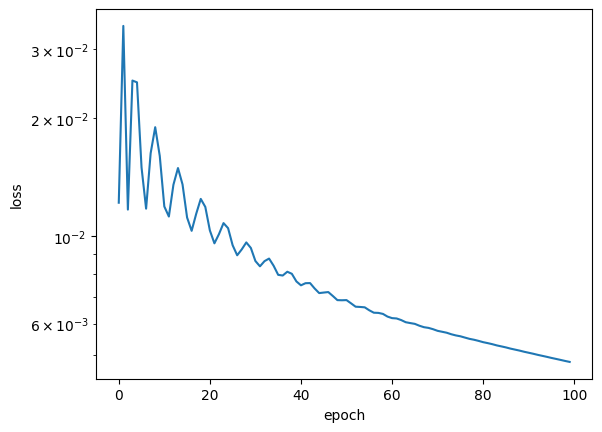

In [ ]:
plt.semilogy(range(epochs), loss_list1)
plt.ylabel("loss")
plt.xlabel("epoch")

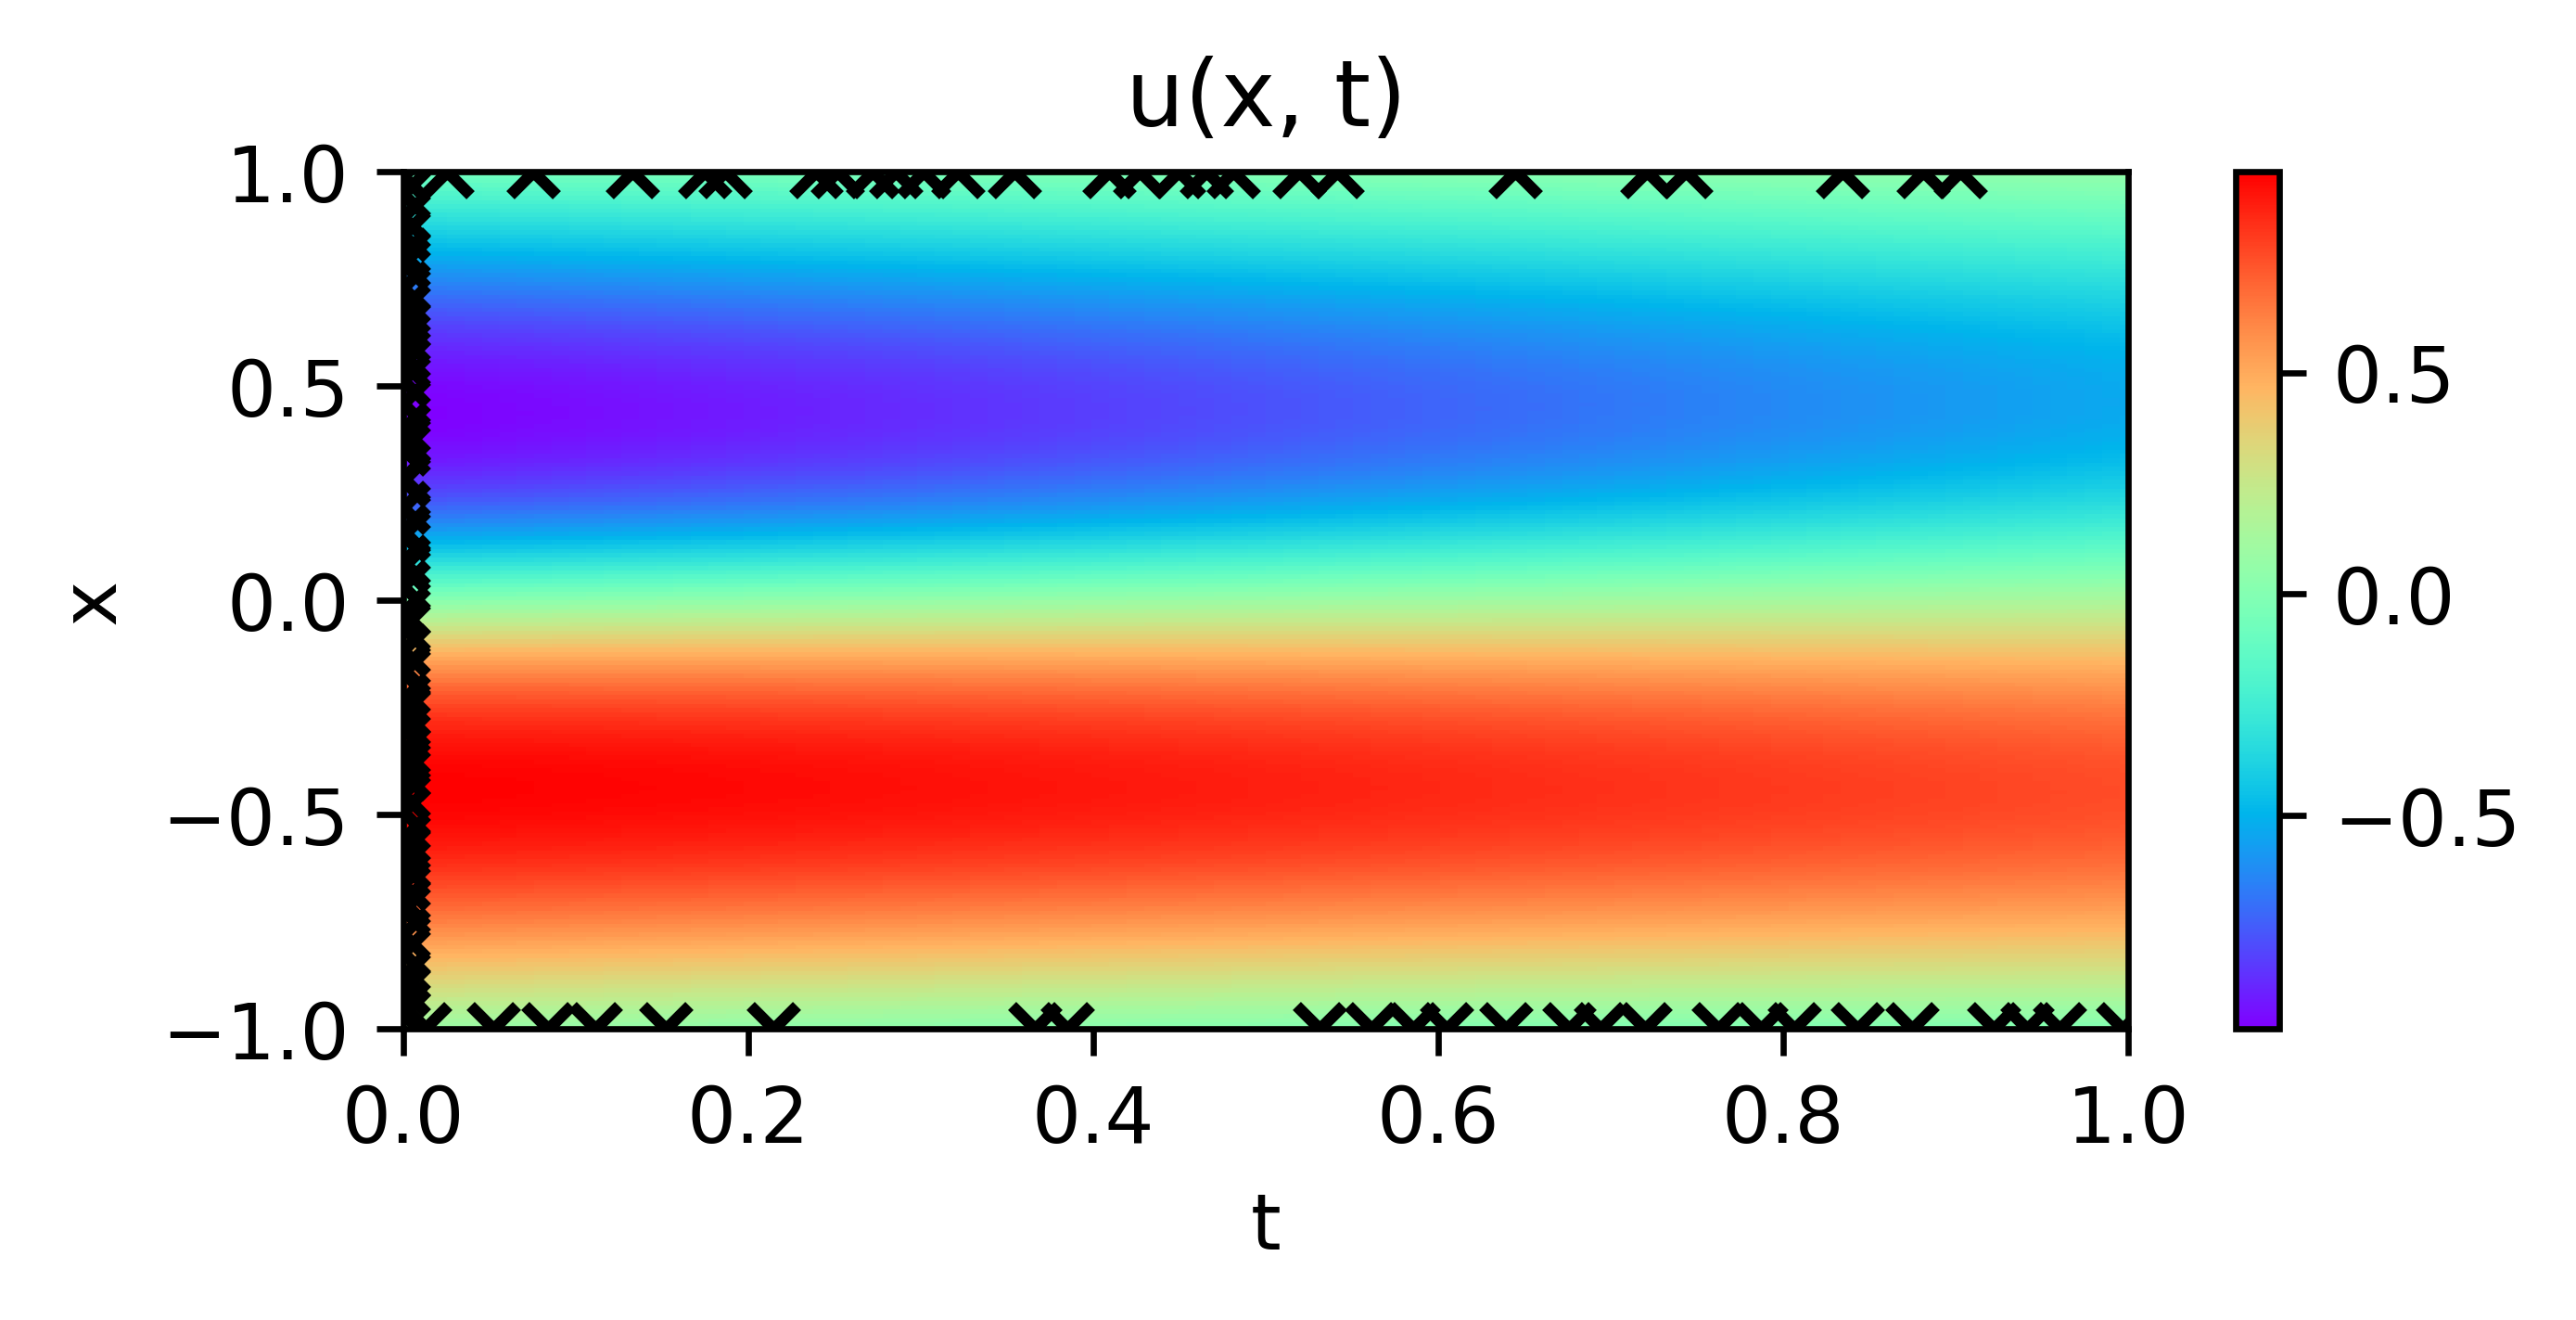

In [ ]:
n, m = 100, 200
X = np.linspace(-1, +1, m)
T = np.linspace(0, 1, n)
X0, T0 = np.meshgrid(X, T)
X = X0.reshape([n*m, 1])
T = T0.reshape([n*m, 1])
X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)
X.shape, T.shape
plt.figure(figsize=(5, 2), dpi=600)
S = u1(T, X)
S = S.numpy().reshape(n, m)
plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(-1, +1)
plt.title("u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
plt.scatter(t_d, x_d, marker="x", c="k")
plt.show()
     

In [ ]:
#Third step 
L = 3000
t_sec = 3
rs = 2700
cs= 3000
r0 = 1000
r1 = rs / r0
m = 0
g = 10
g_ss = g*t_sec**2
alfa_t = L / g_ss
alfa_ps = r1*cs**2 / (alfa_t * L * g)
alfa_pf = 0
alfa_m = 2*5*10**(-3) / (alfa_t * t_sec * L * g * r0)
c1 = 3000
rd1 = 2.7
#rd = m*rf+ (1-m)*rs
print(alfa_t)
print(alfa_ps)
print(alfa_m)

rs3 = 1600
cs3 = 1000
r3 = rs3 / r0 

alfa_ps3 = r3 * cs3**2
alfa_ps32 = alfa_ps3 / (alfa_t * L * g)
m3 = 0
c3 = alfa_ps32
rd3 = 1.6

print(alfa_ps32)

33.333333333333336
24.3
3.3333333333333335e-12
1.6


In [ ]:
@tf.function
def u2(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u

In [ ]:
@tf.function
def f2(x, y):
    u0 = u(x, y)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    F =  (1.0 / rd3) *(u_xx - (1.0 / c3**2)* u_yy)
    return tf.reduce_mean(tf.square(F))

In [ ]:
@tf.function
def mse2(y, y_):
    return tf.reduce_mean(tf.square(y-y_))
     

In [ ]:
epochs = 100
loss_list2 = []

# L-BFGS optimizer was used in the reference paper
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
start = time.time()

# training loop
# IMPORTANT: a while-based training loop is more beneficial
# updates the model while loss > 0.006
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # model output/prediction
        y_ = u2(t_d, x_d)
        # physics-informed loss for collocation points
        L1 = f2(t_c, x_c)
        # MSE loss for data points
        L2 = mse1(y_d, y_)
        loss = L1 + L2
    # compute gradients
    g = tape.gradient(loss, model.trainable_weights)
    loss_list2.append(loss)

    # apply gradients
    opt.apply_gradients(zip(g, model.trainable_weights))

end = time.time()
print(f"{end - start:.3} (s)")

42.3 (s)


In [ ]:
for i in loss_list2:
  print(i)

tf.Tensor(3.500433948471839, shape=(), dtype=float64)
tf.Tensor(3.5334212928366218, shape=(), dtype=float64)
tf.Tensor(3.5011743626432534, shape=(), dtype=float64)
tf.Tensor(3.522392021949995, shape=(), dtype=float64)
tf.Tensor(3.518653741044759, shape=(), dtype=float64)
tf.Tensor(3.504561682558579, shape=(), dtype=float64)
tf.Tensor(3.503443006183639, shape=(), dtype=float64)
tf.Tensor(3.5097221598573722, shape=(), dtype=float64)
tf.Tensor(3.5106092824119015, shape=(), dtype=float64)
tf.Tensor(3.5065670254854684, shape=(), dtype=float64)
tf.Tensor(3.5036209493609762, shape=(), dtype=float64)
tf.Tensor(3.503840861348398, shape=(), dtype=float64)
tf.Tensor(3.504577856387148, shape=(), dtype=float64)
tf.Tensor(3.504258387698041, shape=(), dtype=float64)
tf.Tensor(3.5038206140015404, shape=(), dtype=float64)
tf.Tensor(3.503870402672717, shape=(), dtype=float64)
tf.Tensor(3.5036039801651486, shape=(), dtype=float64)
tf.Tensor(3.5023910902864603, shape=(), dtype=float64)
tf.Tensor(3.5013017

Text(0.5, 0, 'epoch')

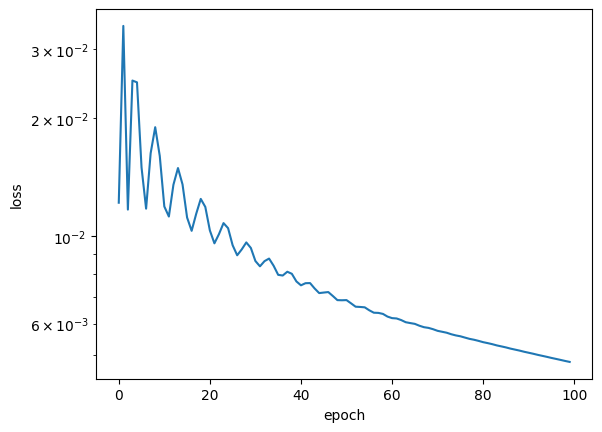

In [ ]:
plt.semilogy(range(epochs), loss_list1)
plt.ylabel("loss")
plt.xlabel("epoch")

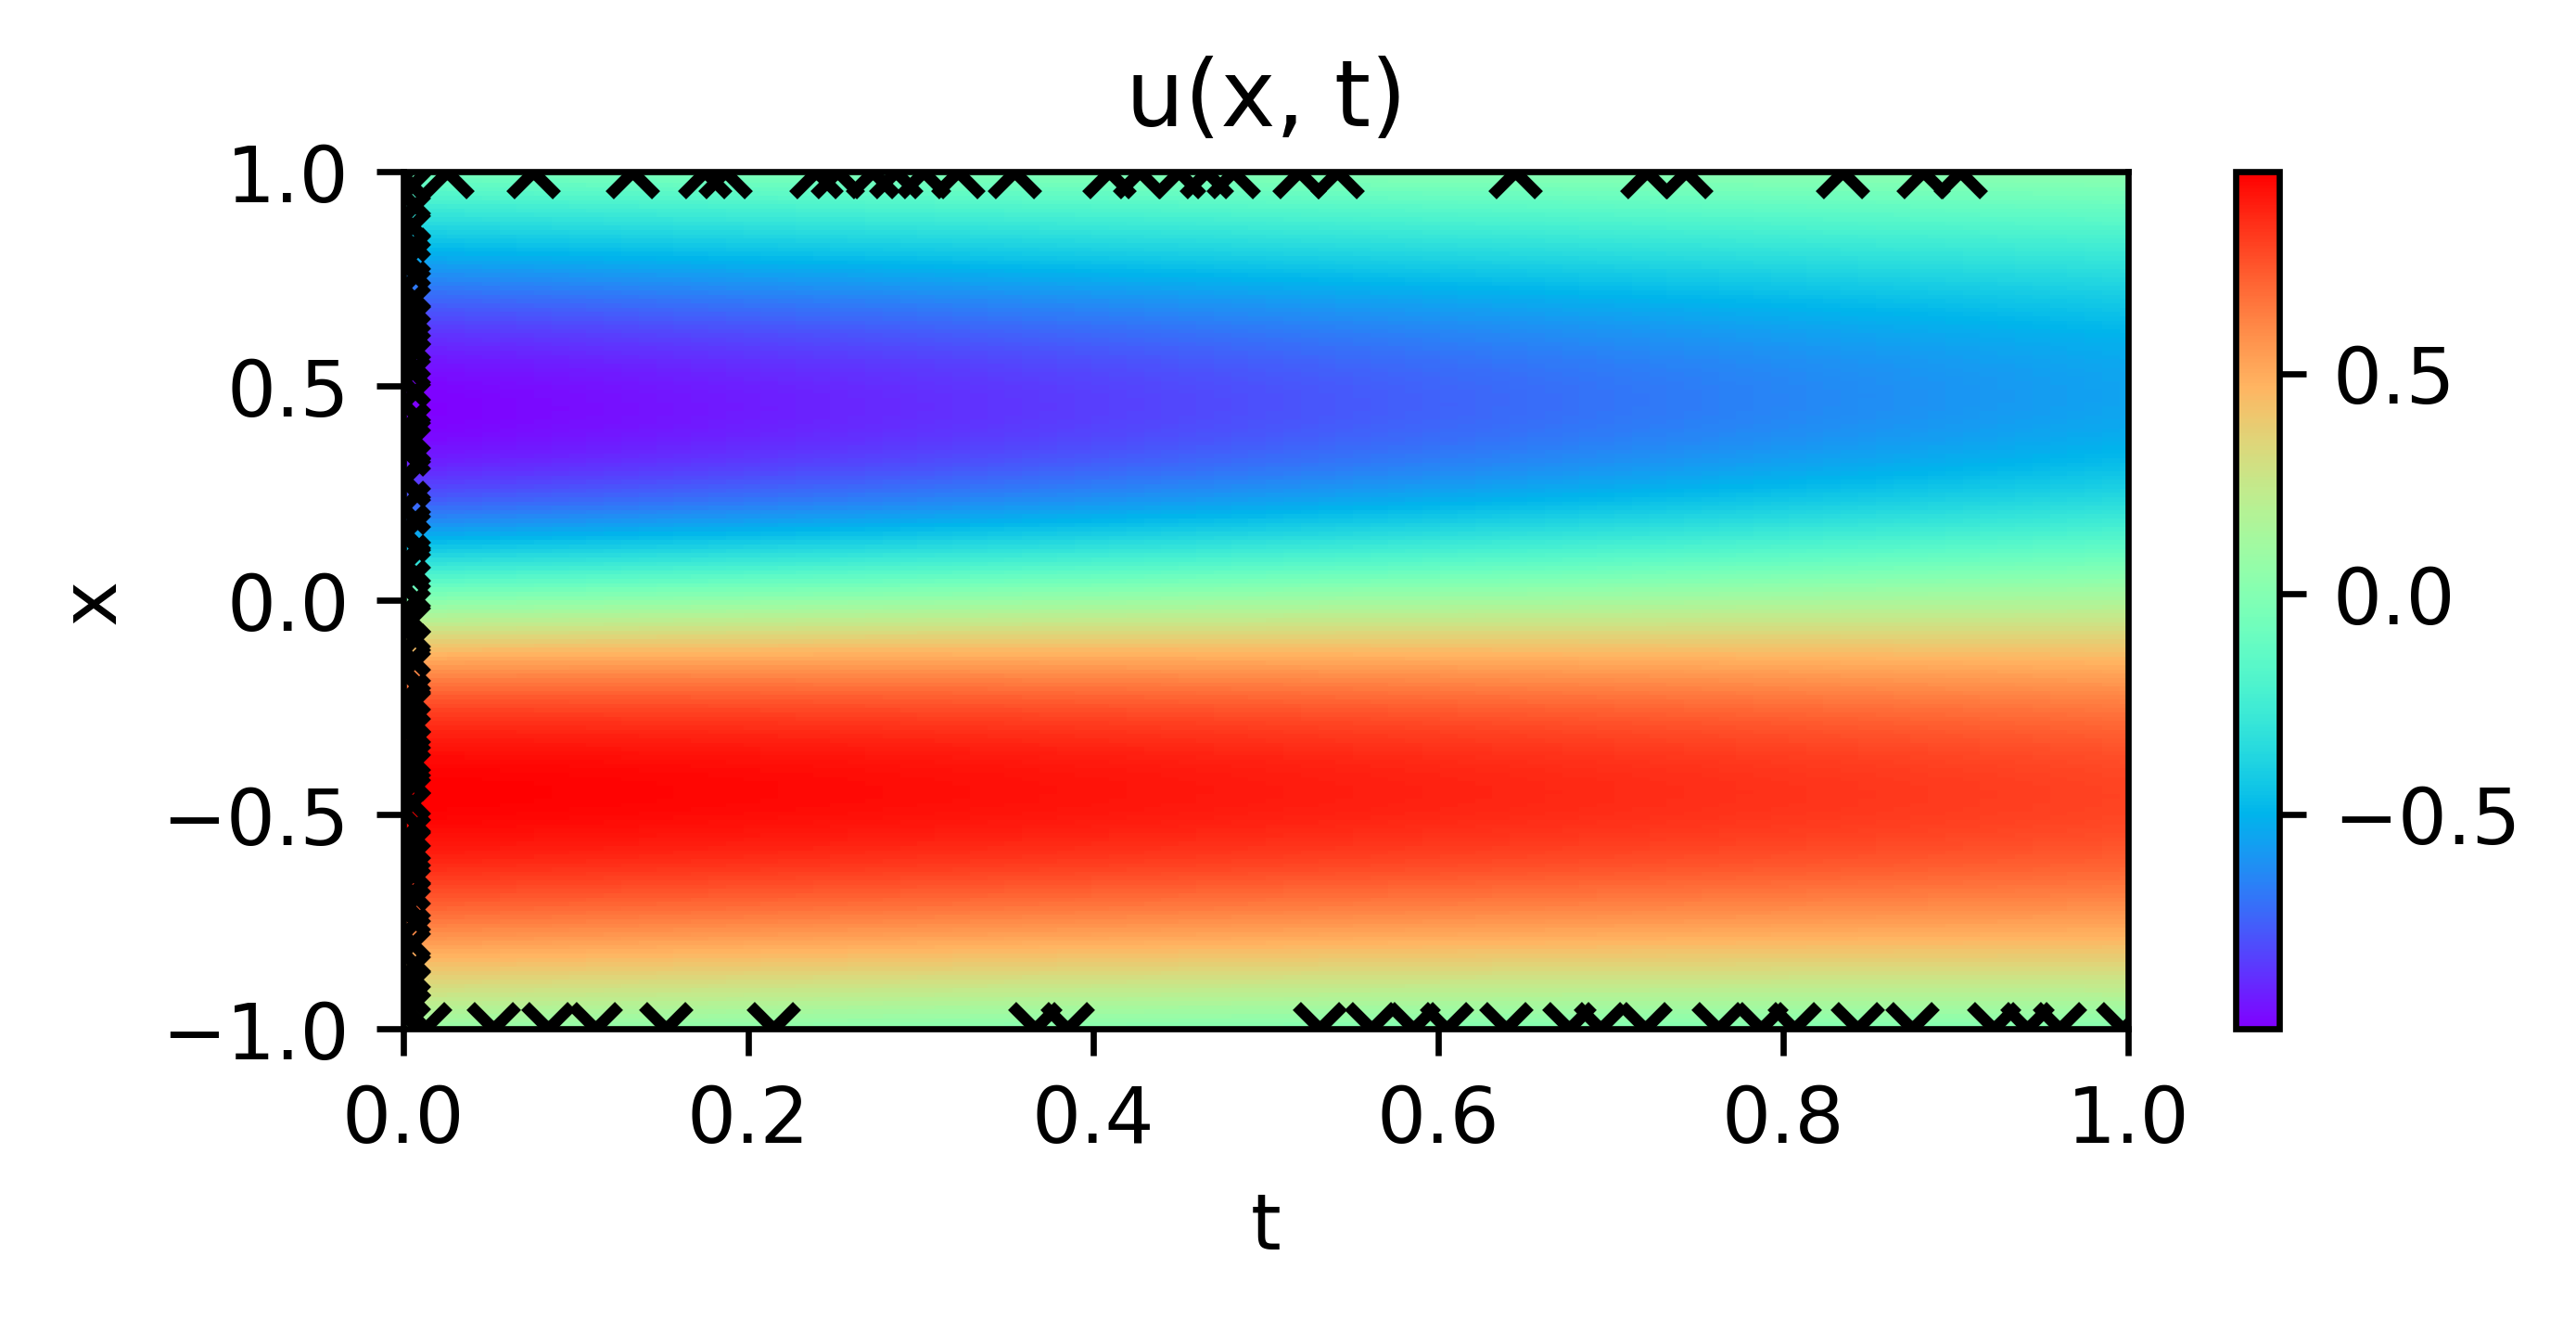

In [ ]:
n, m = 100, 200
X = np.linspace(-1, +1, m)
T = np.linspace(0, 1, n)
X0, T0 = np.meshgrid(X, T)
X = X0.reshape([n*m, 1])
T = T0.reshape([n*m, 1])
X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)
X.shape, T.shape
plt.figure(figsize=(5, 2), dpi=600)
S = u2(T, X)
S = S.numpy().reshape(n, m)
plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(-1, +1)
plt.title("u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
plt.scatter(t_d, x_d, marker="x", c="k")
plt.show()